### Develop DL model using DEA data
follows on from extract_DLchip_by_shapefile.ipynb

In [1]:
import datetime
import numpy as np
import geopandas as gpd
from matplotlib import pyplot

import tensorflow
from tensorflow import keras

#### load and view data

In [2]:
# load saved out data
train_data = np.load('./train_data.npy')
train_data_labels = np.load('./train_data_labels.npy')

validate_data = np.load('./validate_data.npy')
validate_data_labels = np.load('./validate_data_labels.npy')

test_data = np.load('./test_data.npy')
test_data_labels = np.load('./test_data_labels.npy')


In [3]:
# Get overall stats for each band - Only used for visualisation.
mean_red = np.mean(train_data[:,:,:,0])
std_red = np.std(train_data[:,:,:,0])
mean_green = np.mean(train_data[:,:,:,1])
std_green = np.std(train_data[:,:,:,1])
mean_blue = np.mean(train_data[:,:,:,2])
std_blue = np.std(train_data[:,:,:,2])

In [4]:
image_stats = {"red" : (mean_red, std_red),
               "green" : (mean_green, std_green),
               "blue" : (mean_blue, std_blue)}

In [5]:
def apply_std_stretch(in_array, col="red"):
    mean = image_stats[col][0]
    stdev = image_stats[col][1]
    
    sd_min = mean - 2*stdev
    sd_max = mean + 2*stdev
    sd_range = sd_max - sd_min

    out_array = (in_array / sd_range) * 255
    out_array[out_array < 0] = 0
    out_array[out_array > 255] = 255

    return out_array.astype(np.uint8)


def get_rgb(in_image):
    red = apply_std_stretch(in_image[:,:,0], "red")
    green = apply_std_stretch(in_image[:,:,1], "green")
    blue = apply_std_stretch(in_image[:,:,2], "blue")

    return np.dstack([red, green, blue])


In [6]:
# Plot a random chip to check it looks OK.
pyplot.imshow(get_rgb(train_data[np.random.randint(0, train_data.shape[0]),:,:,:]))

In [7]:
# checking data shapes (samples, x, y, no. of bands)
train_data.shape, validate_data.shape, test_data.shape

((4258, 100, 100, 3), (533, 100, 100, 3), (535, 100, 100, 3))

#### Develop DL model - transfer learning based on ResNet50 (from Petes nb)


In [8]:
train_data_labels_one_hot_encoding = keras.utils.to_categorical(train_data_labels, num_classes=6)
valid_data_labels_one_hot_encoding = keras.utils.to_categorical(validate_data_labels, num_classes=6)

In [9]:
# Optional pre-processing step. Left out to make it easier to apply to images (just remaining here)
processed_train = train_data # keras.applications.resnet50.preprocess_input(train_data)
processed_valid = validate_data # keras.applications.resnet50.preprocess_input(valid_data)

In [10]:
# Input shape of image chips
input_shape=(100, 100, 3)

In [11]:
# have downloaded the weights file to make easier
# otherwise weights="imagenet"
restnet = keras.applications.ResNet50(weights="./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
                                      input_shape=input_shape, include_top=False)

In [12]:
# -1 here is the last layer (i.e. the final layer which is the output layer of the cnn model)
output = restnet.layers[-1].output
print(output)
# flatten this output (was shape None, 4, 4, 2048; now 32768)
output = keras.layers.Flatten()(output)
print(output)
# saying to input model as resnet cnn settings, then output model as a 1d array of shape 100352
restnet = keras.models.Model(inputs=restnet.input, outputs=output)

Tensor("conv5_block3_out/Relu:0", shape=(None, 4, 4, 2048), dtype=float32)
Tensor("flatten/Reshape:0", shape=(None, 32768), dtype=float32)


In [13]:
# Turn off trainable for existing layers to keep existing weights
for layer in restnet.layers:
    layer.trainable = False

In [14]:
# building the cnn model here, where model.add adds in the cnn layers sequentially
# note that there is no changing of shape here - i.e. layers.Flatten() as this has been done above
model = keras.models.Sequential()

model.add(restnet)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
# Add softmax for output, set to 6 for 6 classes
#model.add(keras.layers.Dense(2, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.add(keras.layers.Dense(6, activation='softmax'))

In [15]:
# categorical_crossentropy used here as ther are multiple output classes (i.e. 6)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 32768)             23587712  
_________________________________________________________________
dense (Dense)                (None, 32)                1048608   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1

In [16]:
train_epochs = 30

In [17]:
# Fit model
# batch size of 10 and epoch of 1 means the model will be run 76 times (as there is 751 samples of data)

model = model.fit(processed_train, train_data_labels_one_hot_encoding,
          validation_data=(processed_valid, valid_data_labels_one_hot_encoding),
          batch_size=1000, epochs=train_epochs)

Epoch 1/30
5/5 [==============================] - 25s 5s/step - loss: 1.8908 - accuracy: 0.1949 - val_loss: 1.8312 - val_accuracy: 0.2364
Epoch 2/30
5/5 [==============================] - 24s 5s/step - loss: 1.8281 - accuracy: 0.1862 - val_loss: 1.7703 - val_accuracy: 0.2383
Epoch 3/30
5/5 [==============================] - 24s 5s/step - loss: 1.8107 - accuracy: 0.2022 - val_loss: 1.7627 - val_accuracy: 0.2383
Epoch 4/30
5/5 [==============================] - 24s 5s/step - loss: 1.7911 - accuracy: 0.2161 - val_loss: 1.7638 - val_accuracy: 0.2383
Epoch 5/30
5/5 [==============================] - 25s 5s/step - loss: 1.7810 - accuracy: 0.2215 - val_loss: 1.7629 - val_accuracy: 0.2383
Epoch 6/30
5/5 [==============================] - 24s 5s/step - loss: 1.7950 - accuracy: 0.2168 - val_loss: 1.7589 - val_accuracy: 0.2402
Epoch 7/30
5/5 [==============================] - 24s 5s/step - loss: 1.7933 - accuracy: 0.2231 - val_loss: 1.7636 - val_accuracy: 0.2570
Epoch 8/30
5/5 [==================

In [18]:
# Save out model
# here Pete uses .mdl, but keras also has support for h5 i.e. model.save('my_model.h5') 
current_time = datetime.datetime.now().strftime("%Y%m%dT%H%M%S")
out_model_file = f"keras_level3_e{train_epochs}_{current_time}.mdl"
model.model.save(out_model_file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: keras_level3_e30_20201204T115102.mdl/assets


#### Model evaluation

In [19]:
# # load model
# model = keras.models.load_model('./keras_level3_e1_20201127T142328.mdl')

# # Check its architecture
# model.summary()

In [20]:
# plot up to see model evaluation
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(30)

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

#### Predict using model
classes 0 = CTV, 1 = NTV, 2 = NAV, 3 = AS, 4 = BS, 5 = W

In [59]:
# Randomly select
sample_id = np.random.randint(0, test_data.shape[0])

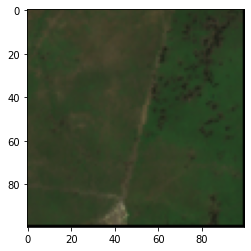

In [60]:
pyplot.imshow(get_rgb(test_data[sample_id,:,:,:]))

In [63]:
# # get a slice of the data, between sample_id and sample_id+1
# # output gives a % confidence of being in a particular class (i.e. 6 values, relating to level 3 classes)
# model.predict(keras.applications.resnet50.preprocess_input(test_data[sample_id:sample_id+1,:,:,:]))
model.model.predict(test_data[sample_id:sample_id+1,:,:,:])

array([[0.08639866, 0.23323302, 0.2873032 , 0.09767192, 0.14832683,
        0.14706638]], dtype=float32)